# HDA - Project 3

## Classification of Modes of Locomotion

This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [10]:
import utils
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from keras.optimizers import Adam

# parameters definition

subject = 1
folder = "./data/reduced/"
label_col = 0     # default for task A
window_size = 50
stride = 50

# Section 1 - Loading and Preprocessing

### Dataset Loading 

In [11]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)


Session shapes:
ADL1:   (45810, 58)
ADL2:   (28996, 58)
ADL3:   (30167, 58)
ADL4:   (30228, 58)
ADL5:   (27308, 58)
Drill:  (52152, 58)

Training samples:  157125 
Test samples:       57536 
Features:             58


### Dataset preparation in order to feed it to the network

In [12]:
# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])

print("Training set:")
X_train_s, Y_train_s = utils.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False)
print("\nTest set:")
X_test_s, Y_test_s = utils.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False)
# add bars plot


Classes in training set:  5 
Classes in test set:      5
Training set:
<class 'numpy.ndarray'> (3141, 50, 58) <class 'numpy.ndarray'> (3141, 5)

Features have shape:  (3141, 50, 58) 
Labels have shape:    (3141, 5) 
Fraction of labels:   [0.11 0.42 0.27 0.17 0.02]

Test set:
<class 'numpy.ndarray'> (1149, 50, 58) <class 'numpy.ndarray'> (1149, 5)

Features have shape:  (1149, 50, 58) 
Labels have shape:    (1149, 5) 
Fraction of labels:   [0.18 0.34 0.2  0.24 0.04]


# Section 2 - Classification with Conv1D

### Creation of one-dimensional convolutional neural network

In [13]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

model_unidim = utils.Model1D((window_size, features), classes)

opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test_s, Y_test_s))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 50, 18)            5238      
_________________________________________________________________
batch_normalization_10 (Batc (None, 50, 18)            72        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 50, 18)            0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 25, 18)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 25, 36)            4572      
_________________________________________________________________
batch_normalization_11 (Batc (None, 25, 36)            144       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 25, 36)            0         
__________

### Classification and evaluation of performances

F1-measure:  0.8467135629025287
AUC w.r. to each class:  {0: 0.9326359789558215, 1: 0.9790684774935288, 2: 0.9537626498410812, 3: 0.9982022940563087, 4: 0.862361168243521}


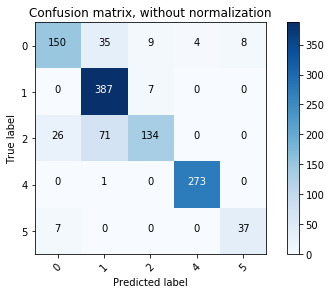

In [14]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')

# Section 3 - Classification with Conv2D

In [15]:
model_new2D = utils.Model2D((1,window_size,features), classes)
opt4 = Adam(lr=0.01)
model_new2D.compile(optimizer = opt4, loss = "categorical_crossentropy", metrics = ["accuracy"])

# need to reshape in order to fit to the new 2D model
X_train = X_train_s.reshape(X_train_s.shape[0], 1, window_size, features)
X_test = X_test_s.reshape(X_test_s.shape[0], 1, window_size, features)

model_new2D.fit(x = X_train, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test, Y_test_s))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 17, 18)         26118     
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 17, 18)         72        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 1, 17, 18)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 9, 18)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 3, 36)          16236     
_________________________________________________________________
batch_normalization_14 (Batc (None, 1, 3, 36)          144       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 1, 3, 36)          0         
__________

### Classification and evaluation of performances

F1-measure:  0.8704165038375372
AUC w.r. to each class:  {0: 0.9328058561294773, 1: 0.9745083537835748, 2: 0.9529279725358156, 3: 0.9991741397288842, 4: 0.8624434389140271}


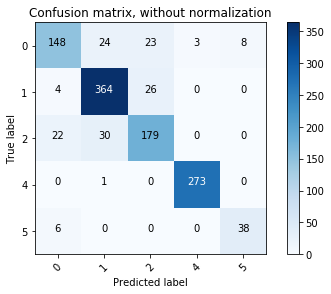

In [16]:
# predict labels
Y_pred_s = model_new2D.predict(X_test)

# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')